In [1]:
from sklift.viz import plot_uplift_preds, plot_uplift_qini_curves

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd; pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split

# Чтение данных
df_clients = pd.read_csv('./data/clients.csv', index_col='client_id')
df_train = pd.read_csv('./data/uplift_train.csv', index_col='client_id')
df_test = pd.read_csv('./data/uplift_test.csv', index_col='client_id')

# Извлечение признаков
df_clients['first_issue_unixtime'] = pd.to_datetime(df_clients['first_issue_date']).astype(np.int64) / 10 ** 9
df_clients['first_redeem_unixtime'] = pd.to_datetime(df_clients['first_redeem_date']).astype(np.int64) / 10 ** 9


df_features = pd.DataFrame({
    'gender_M': (df_clients['gender'] == 'M').astype(int),
    'gender_F': (df_clients['gender'] == 'F').astype(int),
    'gender_U': (df_clients['gender'] == 'U').astype(int),
    'age': df_clients['age'],
    'first_issue_time': df_clients['first_issue_unixtime'],
    'first_redeem_time': df_clients['first_redeem_unixtime'],
    'issue_redeem_delay': df_clients['first_redeem_unixtime'] - df_clients['first_issue_unixtime'],
}).fillna(0)

indices_train = df_train.index
indices_test = df_test.index
indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.3, random_state=123)


ImportError: No module named matplotlib

In [6]:
X_train = df_features.loc[indices_train, :]
y_train = df_train.loc[indices_train, 'target']
treat_train = df_train.loc[indices_train, 'treatment_flg']

X_val = df_features.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, 'target']
treat_val =  df_train.loc[indices_valid, 'treatment_flg']

X_train_full = df_features.loc[indices_train, :]
y_train_full = df_train.loc[:, 'target']
treat_train_full = df_train.loc[:, 'treatment_flg']

X_test = df_features.loc[indices_test, :]

print(df_features.head())
cat_features = ['gender']

models_results = {
    'approach': [],
    'uplift@30%': []
}
print(models_results)

            gender_M  gender_F  gender_U  age  first_issue_time  \
client_id                                                         
000012768d         0         0         1   45      1.501948e+09   
000036f903         0         1         0   72      1.491832e+09   
000048b7a6         0         1         0   68      1.544881e+09   
000073194a         0         1         0   60      1.495544e+09   
00007c7133         0         0         1   67      1.495470e+09   

            first_redeem_time  issue_redeem_delay  
client_id                                          
000012768d       1.515094e+09        1.314656e+07  
000036f903       1.492951e+09        1.118613e+06  
000048b7a6      -9.223372e+09       -1.076825e+10  
000073194a       1.511522e+09        1.597811e+07  
00007c7133       1.546277e+09        5.080682e+07  
{'approach': [], 'uplift@30%': []}


In [19]:
print(models_results)

{'approach': ['SoloModel', 'TwoModels', 'TwoModels_ddr_control', 'TwoModels_ddr_treatment'], 'uplift@30%': [0.03596218919000582, 0.04349829299978847, 0.04184416447626815, 0.0304094031038199]}


## random forest uplift

In [13]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from uplift.ensemble import RandomForestClassifier

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier

rfc1 = RandomForestClassifier(n_estimators = 10, min_samples_leaf = 100, criterion='uplift_RadcliffeSurry')
rfc2 = RandomForestClassifier(n_estimators = 10, min_samples_leaf = 100, criterion='uplift_entropy')
rfc3 = RandomForestClassifier(n_estimators = 10, min_samples_leaf = 100, criterion='uplift_gini')

#fitting
rfc1.fit(X_train, y_train, treat_train)
rfc2.fit(X_train, y_train, treat_train)
rfc3.fit(X_train, y_train, treat_train)

uplift_rfc1 = rfc1.predict_uplift(X_val)

rfc1_score = uplift_at_k(y_true=y_val, uplift=uplift_rfc1, treatment=treat_val, k=0.3)





0.04152882262303992


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002224AFBB348>,
      dtype=object)

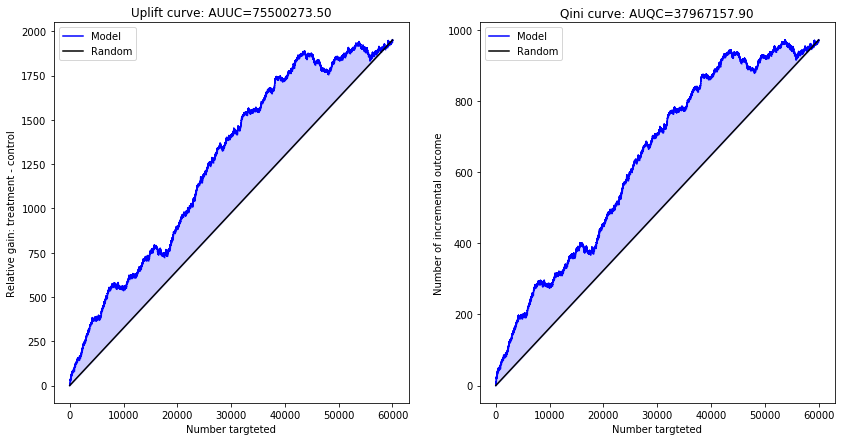

In [14]:
print(rfc1_score)
from sklift.viz import plot_uplift_preds, plot_uplift_qini_curves
plot_uplift_qini_curves(y_true=y_val, uplift=uplift_rfc1, treatment=treat_val)

# Solo

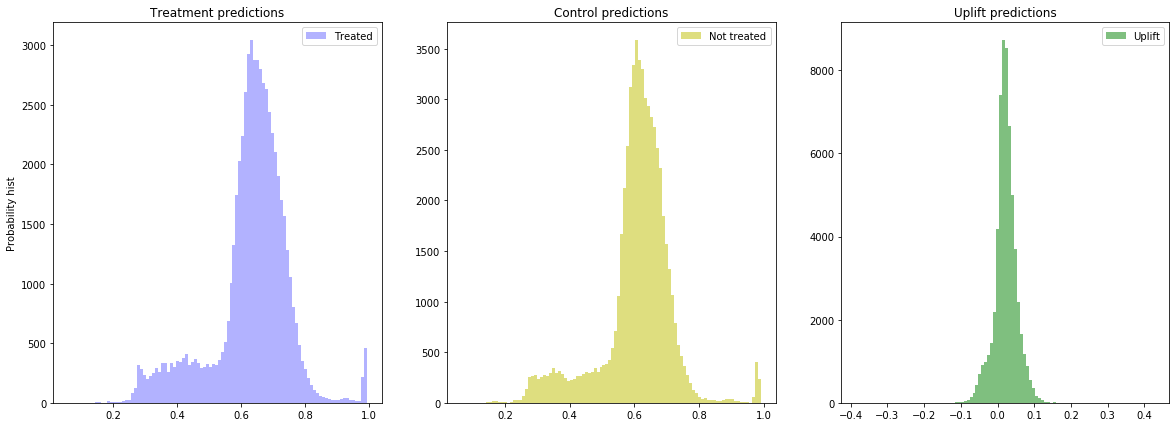

In [8]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier

sm = SoloModel(CatBoostClassifier(thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, k=0.3)

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

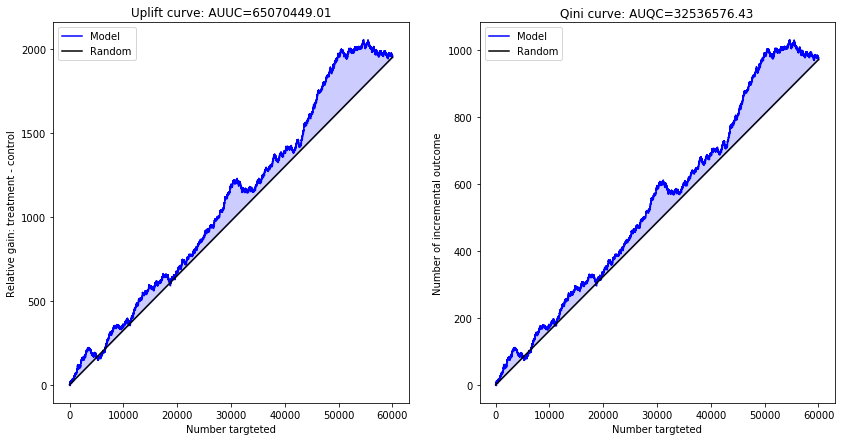

In [10]:
plot_uplift_qini_curves(y_true=y_val, uplift=uplift_sm, treatment=treat_val);

In [1]:

from sklift.models import ClassTransformation

ct = ClassTransformation(CatBoostClassifier(thread_count=2, silent=True, random_state=43))
ct = ct.fit(X_val, y_val, treat_val, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)

NameError: name 'CatBoostClassifier' is not defined

# Two independent models

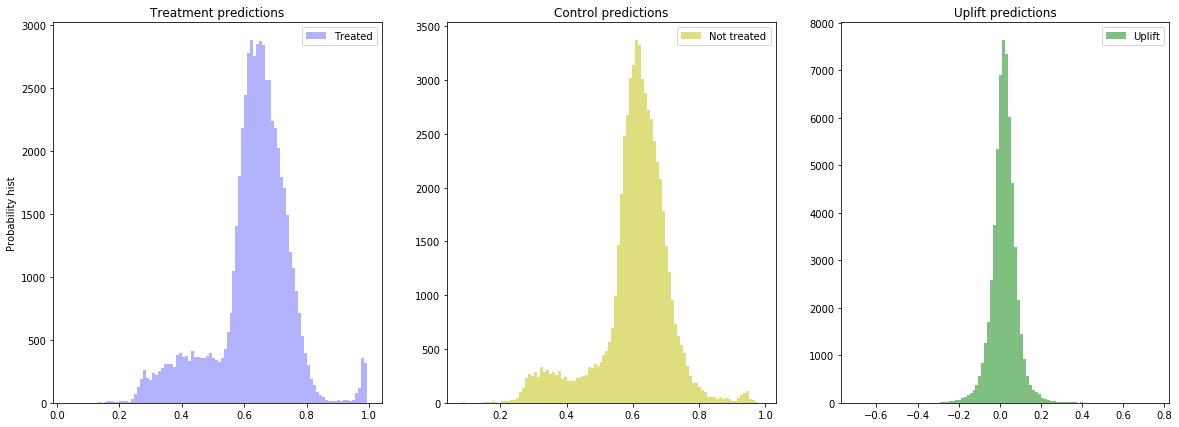

In [11]:
from sklift.models import TwoModels

tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(silent=True, thread_count=2, random_state=42), 
    estimator_ctrl=CatBoostClassifier(silent=True, thread_count=2, random_state=42), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

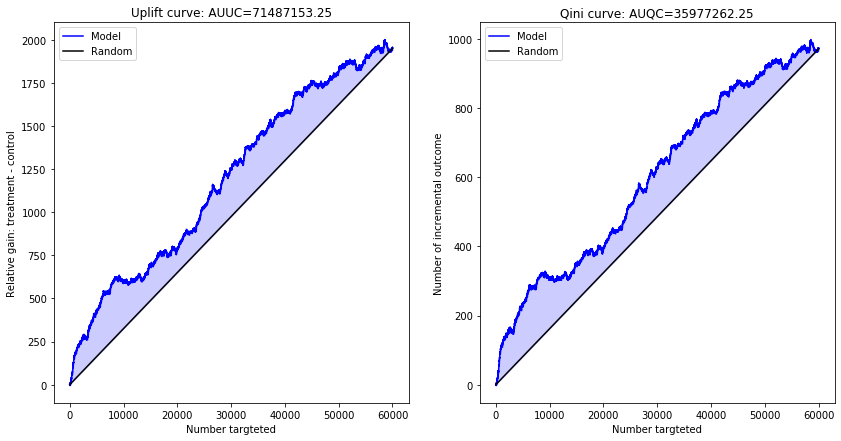

In [13]:
plot_uplift_qini_curves(y_true=y_val, uplift=uplift_tm, treatment=treat_val);

# Two dependent models

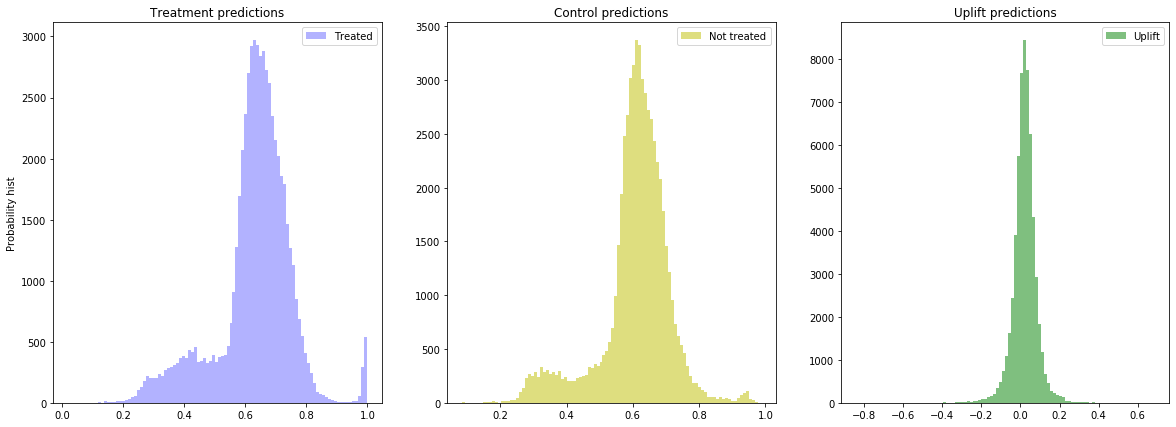

In [14]:
tm_ctrl = TwoModels(
    estimator_trmnt=CatBoostClassifier(silent=True, thread_count=2, random_state=42), 
    estimator_ctrl=CatBoostClassifier(silent=True, thread_count=2, random_state=42), 
    method='ddr_control'
)
tm_ctrl = tm_ctrl.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm_ctrl = tm_ctrl.predict(X_val)

tm_ctrl_score = uplift_at_k(y_true=y_val, uplift=uplift_tm_ctrl, treatment=treat_val, k=0.3)

models_results['approach'].append('TwoModels_ddr_control')
models_results['uplift@30%'].append(tm_ctrl_score)

plot_uplift_preds(trmnt_preds=tm_ctrl.trmnt_preds_, ctrl_preds=tm_ctrl.ctrl_preds_);

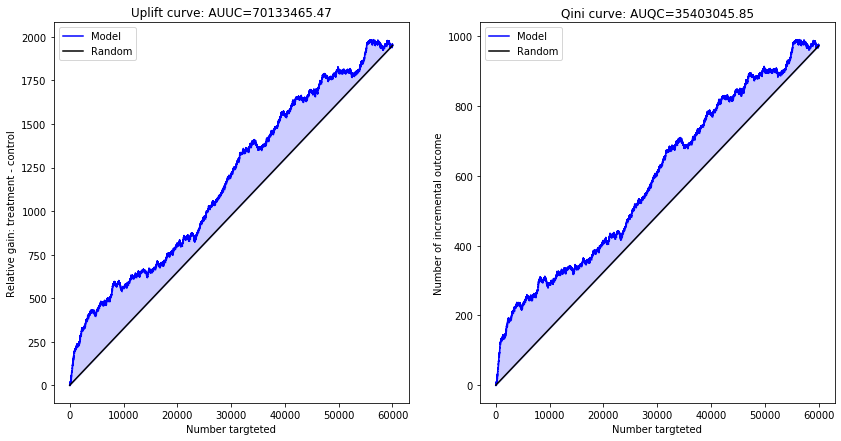

In [16]:
plot_uplift_qini_curves(y_true=y_val, uplift=uplift_tm_ctrl, treatment=treat_val);

# Two dependent models treat

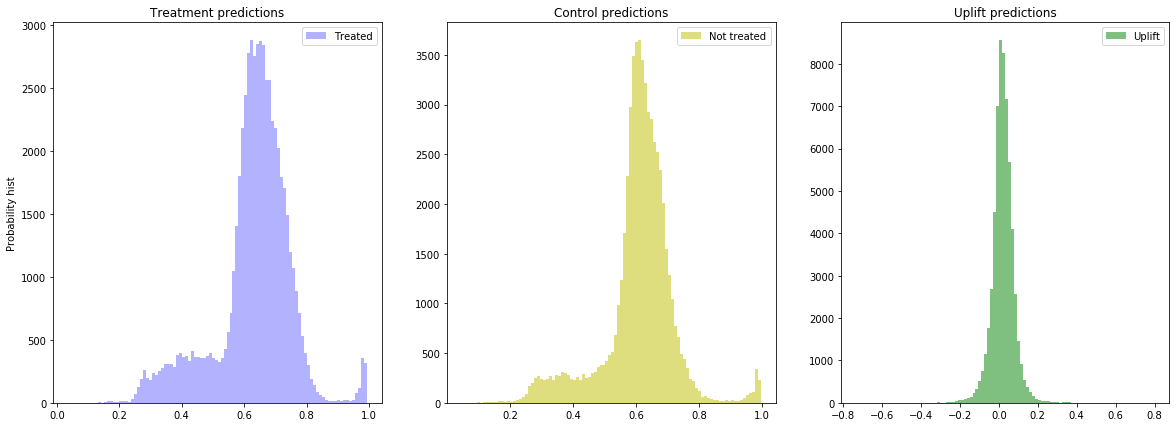

In [17]:
tm_trmnt = TwoModels(
    estimator_trmnt=CatBoostClassifier(silent=True, thread_count=2, random_state=42), 
    estimator_ctrl=CatBoostClassifier(silent=True, thread_count=2, random_state=42), 
    method='ddr_treatment'
)
tm_trmnt = tm_trmnt.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm_trmnt = tm_trmnt.predict(X_val)

tm_trmnt_score = uplift_at_k(y_true=y_val, uplift=uplift_tm_trmnt, treatment=treat_val, k=0.3)

models_results['approach'].append('TwoModels_ddr_treatment')
models_results['uplift@30%'].append(tm_trmnt_score)

plot_uplift_preds(trmnt_preds=tm_trmnt.trmnt_preds_, ctrl_preds=tm_trmnt.ctrl_preds_);

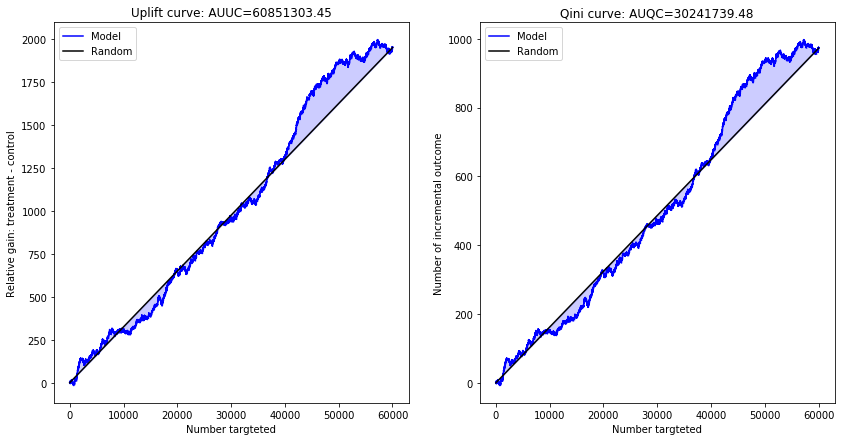

In [18]:
plot_uplift_qini_curves(y_true=y_val, uplift=uplift_tm_trmnt, treatment=treat_val);

In [7]:
from sklearn.base import BaseEstimator
class ClassTransformation(BaseEstimator):
    def __init__(self, estimator):
        self.estimator = estimator
        self._type_of_target = None
    def fit(self, X, y, treatment, estimator_fit_params=None):
        check_consistent_length(X, y, treatment)
        self._type_of_target = type_of_target(y)

        if self._type_of_target != 'binary':

            raise ValueError("This approach is only suitable for binary classification problem")

    

        _, treatment_counts = np.unique(treatment, return_counts=True)

        if treatment_counts[0] != treatment_counts[1]:
            #так как метод использует предлоположение о равенстве 2-х групп
            warnings.warn(

                "Current sample size is unbalanced.",

                category = UserWarning,

                stacklevel = 2

            )



        y_mod = (np.array(y) == np.array(treatment)).astype(int)



        if estimator_fit_params is None:

            estimator_fit_params = {}

        self.estimator.fit(X, y_mod, **estimator_fit_params)

        return self



    def predict(self, X):

        uplift = 2 * self.estimator.predict_proba(X)[:, 1] - 1

        return uplift

In [15]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils.validation import check_consistent_length
from sklearn.utils.multiclass import type_of_target
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
import warnings


cm_full = ClassTransformation(GradientBoostingClassifier()) #CatBoostClassifier(silent=True, thread_count=2, random_state=43)
cm_full = cm_full.fit(X_train, y_train, treat_train)

D:\CV\Anaconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  # Remove the CWD from sys.path while we load stuff.


In [16]:
transf_pred = cm_full.predict(X_val)

uplift_at_k_transf 0.08717030726003805


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000159B3B3ED88>,
      dtype=object)

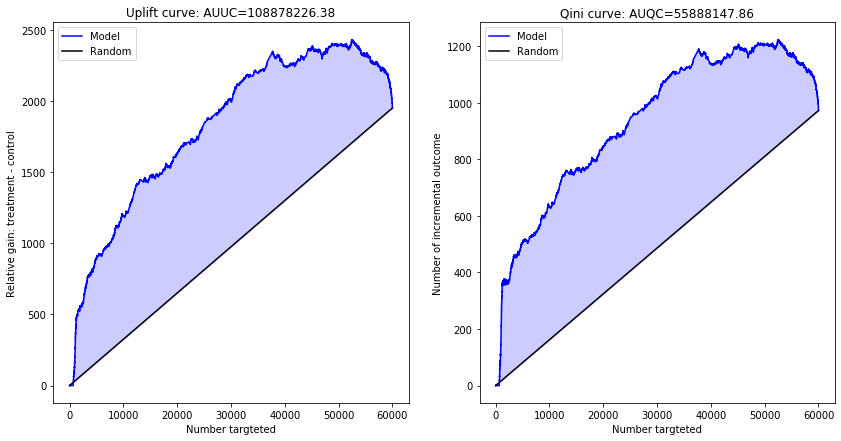

In [17]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds, plot_uplift_qini_curves


score_transf = uplift_at_k(y_true=y_val, uplift=transf_pred, treatment=treat_val, k=0.3)

print("uplift_at_k_transf", score_transf)
plot_uplift_qini_curves(y_true=y_val, uplift=transf_pred, treatment=treat_val)

In [22]:
print(len(treat_train))
indicis_new1 =[]
indicis_new2 =[]
sums = 0
for i in range (0,200039):
 
    if treat_train[i] == 1:
        sums +=1
print(200039 -sums)## 0
print(sums)## 1

for i in range(0,99981):
    if 

200039
100058
99981


# DATASET Criteo-Uplift
## 1) solo


In [35]:
N_ROWS = 1000000 #number of samples

df_dataset = pd.read_csv("DATASETS/criteo-uplift.csv",nrows = N_ROWS)
# print(df_dataset.head)

df_features = pd.DataFrame({
    'f0': df_dataset['f0'],
    'f1': df_dataset['f1'],
    'f2': df_dataset['f2'],
    'f3': df_dataset['f3'],
    'f4': df_dataset['f4'],
    'f5': df_dataset['f5'],
    'f6': df_dataset['f6'],
    'f7': df_dataset['f7'],
    'f8': df_dataset['f8'],
    'f9': df_dataset['f9'],
    'f10': df_dataset['f10'],
    'f11': df_dataset['f11'],
})
#fit on 
indices_train = [i for i in range(0,N_ROWS // 2)]
indices_test = [i for i in range(N_ROWS // 2,N_ROWS)]



X_train = df_features.loc[indices_train].values.astype(float)
treatment_train = df_dataset.loc[indices_train,'treatment'].values
visit_train = df_dataset.loc[indices_train,'visit'].values

X_test = df_features.loc[indices_test].values.astype(float)
Y_test_visit =  df_dataset.loc[indices_test,'visit'].values
treatment_test = df_dataset.loc[indices_test,'treatment'].values
models_results = {
    'approach': [],
    'uplift@30%': []
}

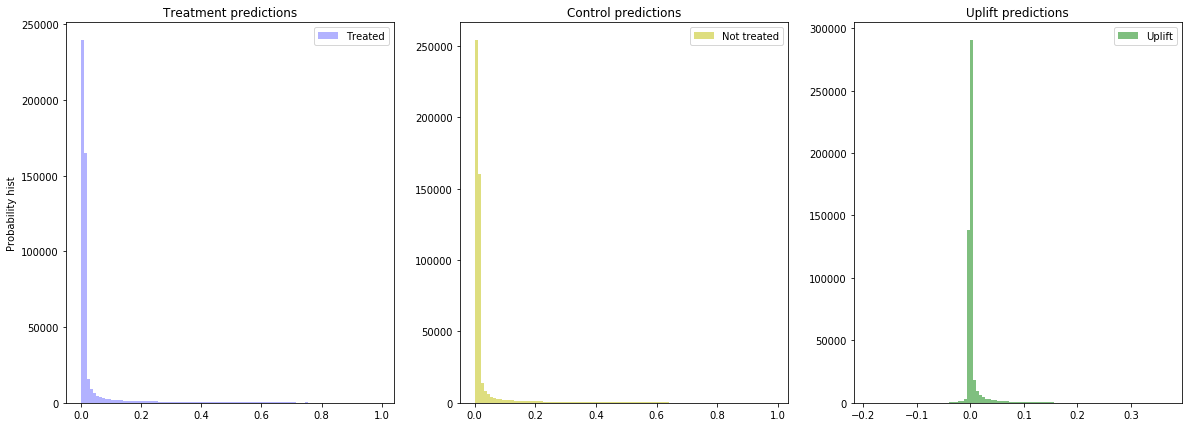

In [36]:

from catboost import CatBoostClassifier

sm = SoloModel(CatBoostClassifier(thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, visit_train, treatment_train)

uplift_sm = sm.predict(X_test )

sm_score = uplift_at_k(y_true=Y_test_visit, uplift=uplift_sm, treatment=treatment_test, k=0.3)

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

D:\CV\Anaconda\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
D:\CV\Anaconda\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


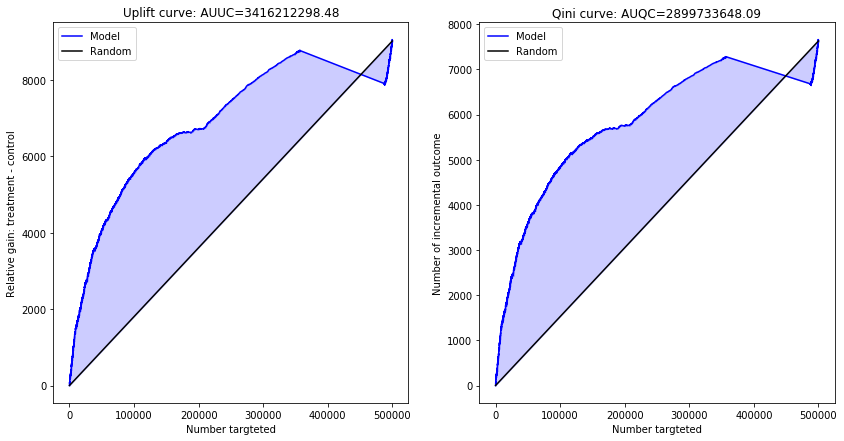

In [37]:
plot_uplift_qini_curves(y_true=Y_test_visit, uplift=uplift_sm, treatment=treatment_test);

## 2) Two independent models 

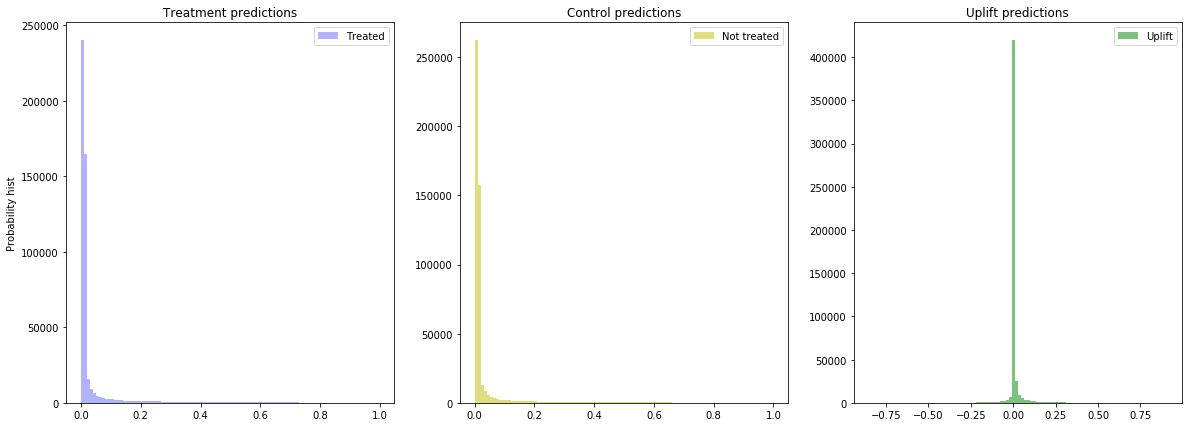

In [40]:
from sklift.models import TwoModels

tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(silent=True, thread_count=2, random_state=42), 
    estimator_ctrl=CatBoostClassifier(silent=True, thread_count=2, random_state=42), 
    method='vanilla'
)
tm = tm.fit(X_train, visit_train, treatment_train)

uplift_tm = tm.predict(X_test)

tm_score = uplift_at_k(y_true=Y_test_visit, uplift=uplift_tm, treatment=treatment_test, k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)0.


plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);



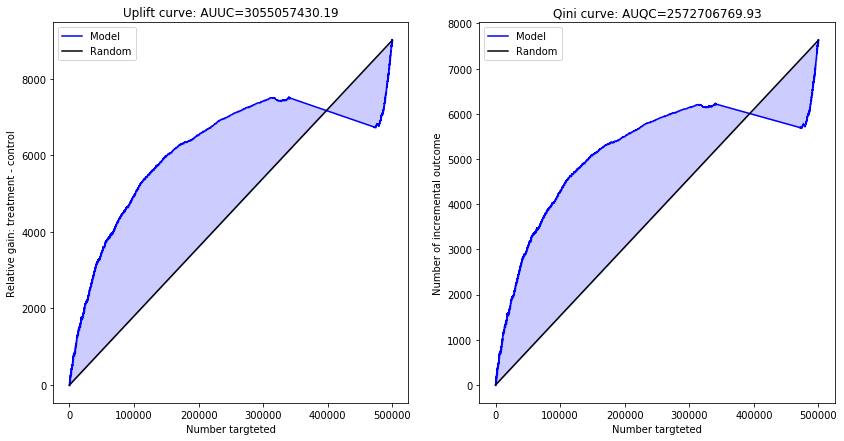

In [41]:
plot_uplift_qini_curves(y_true=Y_test_visit, uplift=uplift_tm, treatment=treatment_test);

## 3) Two dependent models

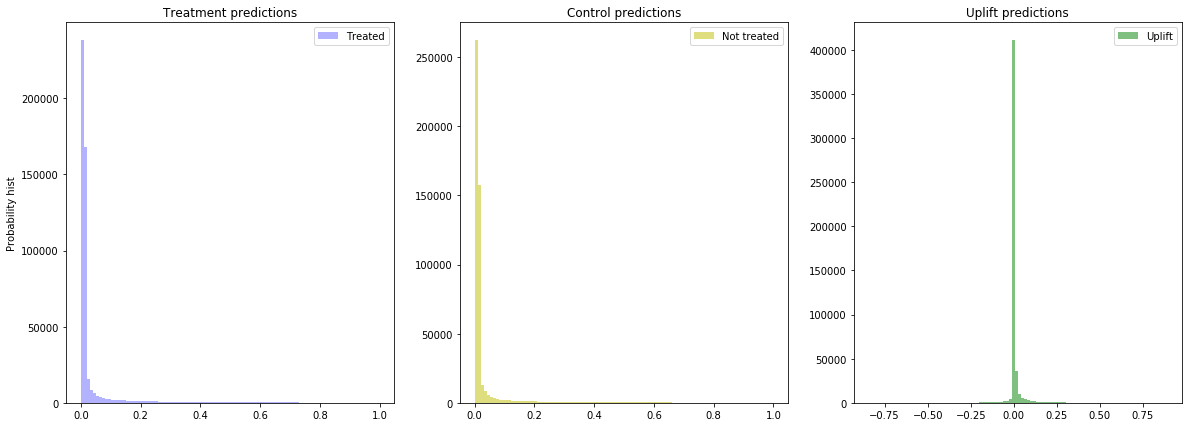

In [43]:
tm_ctrl = TwoModels(
    estimator_trmnt=CatBoostClassifier(silent=True, thread_count=2, random_state=42), 
    estimator_ctrl=CatBoostClassifier(silent=True, thread_count=2, random_state=42), 
    method='ddr_control'
)
tm_ctrl = tm_ctrl.fit(X_train, visit_train, treatment_train)

uplift_tm_ctrl = tm_ctrl.predict(X_test)

tm_ctrl_score = uplift_at_k(y_true=Y_test_visit, uplift=uplift_tm_ctrl, treatment=treatment_test, k=0.3)

models_results['approach'].append('TwoModels_ddr_control')
models_results['uplift@30%'].append(tm_ctrl_score)

plot_uplift_preds(trmnt_preds=tm_ctrl.trmnt_preds_, ctrl_preds=tm_ctrl.ctrl_preds_);

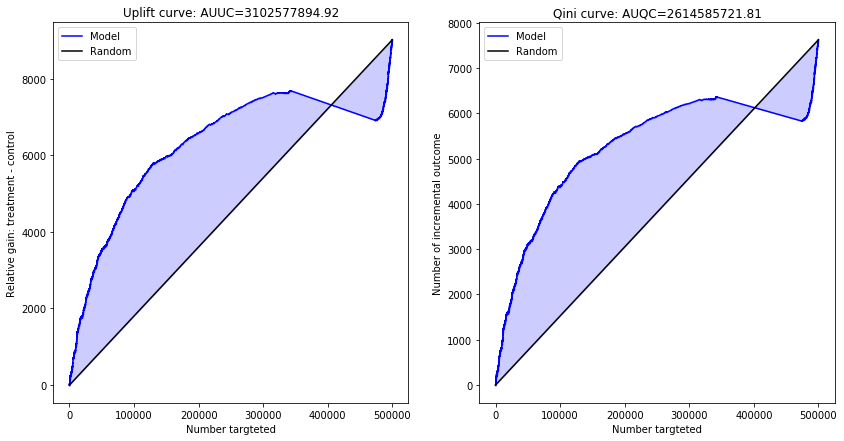

In [44]:
plot_uplift_qini_curves(y_true=Y_test_visit, uplift=uplift_tm_ctrl, treatment=treatment_test);

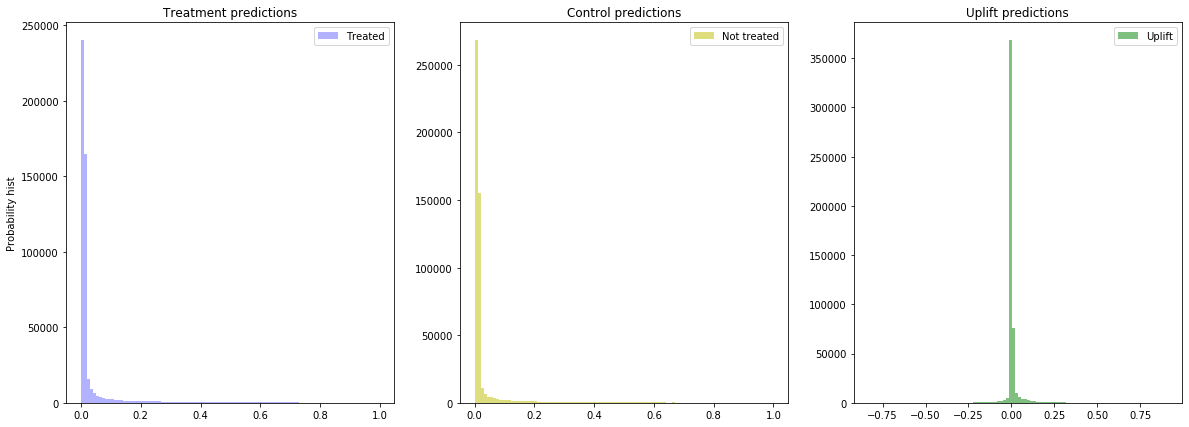

In [46]:
tm_trmnt = TwoModels(
    estimator_trmnt=CatBoostClassifier(silent=True, thread_count=2, random_state=42), 
    estimator_ctrl=CatBoostClassifier(silent=True, thread_count=2, random_state=42), 
    method='ddr_treatment'
)
tm_trmnt = tm_trmnt.fit(X_train, visit_train, treatment_train)

uplift_tm_trmnt = tm_trmnt.predict(X_test)

tm_trmnt_score = uplift_at_k(y_true=Y_test_visit, uplift=uplift_tm_trmnt, treatment=treatment_test, k=0.3)

models_results['approach'].append('TwoModels_ddr_treatment')
models_results['uplift@30%'].append(tm_trmnt_score)

plot_uplift_preds(trmnt_preds=tm_trmnt.trmnt_preds_, ctrl_preds=tm_trmnt.ctrl_preds_);

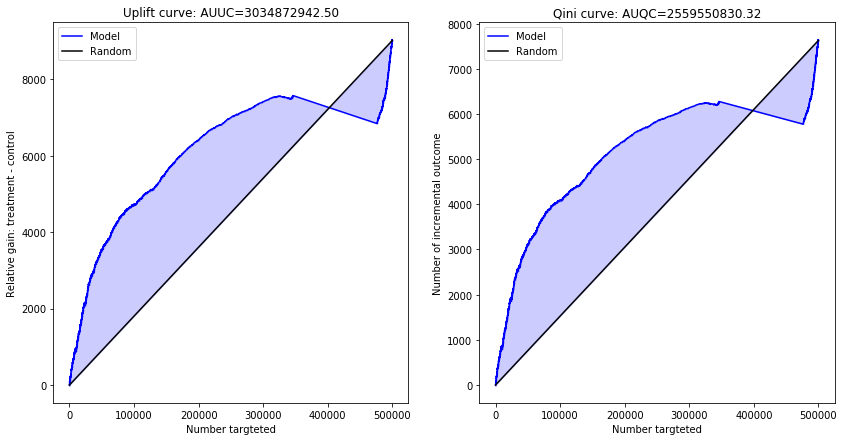

In [47]:
plot_uplift_qini_curves(y_true=Y_test_visit, uplift=uplift_tm_trmnt, treatment=treatment_test);

In [48]:
print(models_results)

{'approach': ['SoloModel', 'TwoModels', 'TwoModels_ddr_control', 'TwoModels_ddr_treatment'], 'uplift@30%': [0.04946423978714295, 0.04129984349291466, 0.04188586684668713, 0.04125257557837505]}
